# [VQ-VAE](https://arxiv.org/abs/1711.00937) for audio in PyTorch

This notebook is based on 
https://github.com/zalandoresearch/pytorch-vq-vae

## Introduction

Variational Auto Encoders (VAEs) can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or seperating out the data. Thus given some data we can think of using a neural network for representation generation. 

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

### Code

I have followed the code from the TensorFlow implementation by the author which you can find here [vqvae.py](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py) and [vqvae_example.ipynb](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb). 

Another PyTorch implementation is found at [pytorch-vqvae](https://github.com/ritheshkumar95/pytorch-vqvae).


## Basic Idea

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector $e_i$.

The model will take in batches of waveforms, of size 16126 for our example, and pass it through a ConvNet encoder producing some output, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index. 

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed audio. 

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

## Loss

The total loss is composed of three components:

1. reconstruction loss which optimizes the decoder and encoder
1. due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
1. also since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

In [1]:
import os
import subprocess

import math

import matplotlib.pyplot as plt
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
import torch.optim as optim

from audio_loader import VCTK
from wavenet_vocoder.wavenet import WaveNet
from wavenet_vocoder.wavenet import receptive_field_size

In [3]:
device = torch.device("cuda")

In [4]:
class SubsetSequentialSampler(Sampler):
    r"""Samples elements from a given list of indices sequentially, always in the same order.

    Arguments:
        indices (sequence): a sequence of indices
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)
    
    def __len__(self):
        return len(self.indices)

## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCL` tensor of shape `[16, 64, 32]`, we will first convert it to an `BLC` tensor of shape `[16, 32, 64]` and then reshape it into `[512, 64]` and all `512` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `512` in this case. The number of channels of the encoder output must be equal to the embedding_dim.

In [5]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        assert len(inputs.shape) == 3
        # convert inputs from BCL -> BLC (B - batch size, C - channels, L - length)
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
    
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BLC -> BCL
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [38]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCL -> BLC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
    
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        loss = self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BLC -> BCL
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity

## Encoder & Decoder Architecture

In [39]:
class Encoder(nn.Module):
    """Audio encoder
    The vq-vae paper says that the encoder has 6 strided convolutions with stride 2 and window-size 4.
    The number of channels and a nonlinearity is not specified in the paper. I use ReLU.
    """
    def __init__(self, encoding_channels, in_channels=256):
        super(Encoder,self).__init__()
        self._num_layers = 2 * len(encoding_channels) - 1
        self._layers = nn.ModuleList()
        for out_channels in encoding_channels:
            self._layers.append(nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    stride=2,
                                    kernel_size=4,
                                    padding=0, 
                                        ))
            self._layers.append(nn.ReLU())
            in_channels = out_channels
        self._layers = self._layers[:-1] #remove ReLu from last layer
        
    def forward(self, x):
        for i in range(self._num_layers):
            x = self._layers[i](x)
        return x

In [40]:
class Model(nn.Module):
    def __init__(self,
                 encoding_channels,
                 num_embeddings, 
                 embedding_dim,
                 commitment_cost, 
                 layers,
                 stacks,
                 kernel_size,
                 decay=0):
        super(Model, self).__init__()       
        self._encoder = Encoder(encoding_channels=encoding_channels)
        #I tried adding batch normalization here, because:
        #the distribution of encoded values needs to be similar to the distribution of embedding vectors
        #otherwise we'll see "posterior collapse": all values will be assigned to the same embedding vector,
        #and stay that way (because vectors which do not get assigned anything do not get updated).
        #Batch normalization is a way to fix that. But it didn't work: model
        #reproduced voice correctly, but the words were completely wrong.
        #self._batch_norm = nn.BatchNorm1d(1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = WaveNet(out_channels=256, #dimension of ohe mu-quantized signal
                                layers=layers, #like in original WaveNet
                                stacks=stacks,
                                residual_channels=512,
                                gate_channels=512,
                                skip_out_channels=512,
                                kernel_size=kernel_size, 
                                dropout=1 - 0.95,
                                cin_channels=1, #local conditioning channels - on encoder output
                                gin_channels=109, #global conditioning channels - on speaker_id
                                n_speakers=109,
                                weight_normalization=False, 
                                upsample_conditional_features=True, 
                                decoding_channels=encoding_channels[::-1],
                                use_speaker_embedding=False
                               )
        self.receptive_field = receptive_field_size(total_layers=layers, num_cycles=stacks, kernel_size=kernel_size)
        self.mean = None
        self.std = None
    def forward(self, x):
        audio, target, speaker_id = x
        assert len(audio.shape) == 3 # B x C x L 
        assert audio.shape[1] == 256
        z = self._encoder(audio)
        #normalize output - subtract mean, divide by standard deviation
        #without this, perplexity goes to 1 almost instantly
        if self.mean is None:
            self.mean = z.mean().detach()
        if self.std is None:
            self.std = z.std().detach()
        z = z - self.mean
        z = z / self.std
        
        vq_loss, quantized, perplexity = self._vq_vae(z)
        assert z.shape == quantized.shape
        x_recon = self._decoder(audio, quantized, speaker_id, softmax=False)
        
        x_recon = x_recon[:, :, self.receptive_field:-1]
        recon_loss = torch.nn.CrossEntropyLoss()
        recon_loss_value = recon_loss(x_recon, target[:, 1:])
        loss = recon_loss_value + vq_loss
        
        return loss, recon_loss_value, x_recon, perplexity

# Train

In [41]:
num_training_updates = 39818
#vector quantizer parameters:
encoding_channels = [16,16,16,4,4,1]
embedding_dim = 1 #dimension of each vector
num_embeddings = 512 #number of vectors
commitment_cost = 0.25

#wavenet parameters:
kernel_size=2
total_layers=30
num_cycles=3


decay = 0.99
#decay = 0

learning_rate = 3e-4

In [42]:
receptive_field = receptive_field_size(total_layers=total_layers, num_cycles=num_cycles, kernel_size=kernel_size)
print(receptive_field)

3070


## Load data

In [43]:
from audio_loader import VCTK

In [44]:
model = Model(num_embeddings=num_embeddings,
              encoding_channels=encoding_channels,
              embedding_dim=embedding_dim, 
              commitment_cost=commitment_cost, 
              layers=total_layers,
              stacks=num_cycles,
              kernel_size=kernel_size,
              decay=decay).to(device)

In [45]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           mode='min', 
                                                           factor=0.2, 
                                                           patience=50000, 
                                                           verbose=True, 
                                                           threshold=0.0001,
                                                           threshold_mode='rel',
                                                           cooldown=0, 
                                                           min_lr=0, 
                                                           eps=1e-08)

In [48]:
data = VCTK("../VCTK", receptive_field=receptive_field)
print(len(data))
indices = np.arange(len(data))
test_size = len(data) // 10

train_indices = indices[:-test_size]
test_indices = indices[-test_size:]

training_loader = DataLoader(data, 
                           batch_size=1,
                           shuffle=False, 
                           num_workers=1,
                           sampler=SubsetSequentialSampler(train_indices))

validation_loader = DataLoader(data, 
                           batch_size=1,
                           shuffle=False, 
                           num_workers=1,
                           sampler=SubsetSequentialSampler(test_indices))

44242


In [49]:
len(train_indices), len(test_indices)

(39818, 4424)

In [51]:
# model.load_state_dict(torch.load("mymodel"))
# optimizer.load_state_dict(torch.load("myoptim"))

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []
# with open("errors", "rb") as file:
#     train_res_recon_error, train_res_perplexity = pickle.load(file)
num_epochs = 7
num_restarts = 0
for epoch in range(num_epochs):
    torch.save(model.state_dict(), "mymodel")
    torch.save(optimizer.state_dict(), "myoptim")
    iterator = iter(training_loader)
    for i, data_train in enumerate(iterator):

        data_train = [data_train[0].to(device),
                     data_train[1].to(device),
                     data_train[2].to(device)
                     ]
        optimizer.zero_grad()

        loss, recon_error, data_recon, perplexity = model(data_train)
        loss.backward()
        if perplexity == 1:
            num_restarts += 1
            model.load_state_dict(torch.load("mymodel"))
            optimizer.load_state_dict(torch.load("myoptim"))
            break
        optimizer.step()
        scheduler.step(loss)

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

        if (i+1) % 10 == 0:
            print('%d iterations' % (i+1))
            print('recon_error: %.8f' % np.mean(train_res_recon_error[-100:]))
            print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
            print()

10 iterations
recon_error: 5.51628270
perplexity: 20.417

20 iterations
recon_error: 5.49211884
perplexity: 11.803

30 iterations
recon_error: 5.47642159
perplexity: 9.335

40 iterations
recon_error: 5.45427082
perplexity: 8.212

50 iterations
recon_error: 5.45170814
perplexity: 7.643

60 iterations
recon_error: 5.43244236
perplexity: 7.311

70 iterations
recon_error: 5.42302215
perplexity: 7.164

80 iterations
recon_error: 5.41868126
perplexity: 7.103

90 iterations
recon_error: 5.39048285
perplexity: 7.073

100 iterations
recon_error: 5.35158467
perplexity: 7.091

110 iterations
recon_error: 5.21787897
perplexity: 5.784

120 iterations
recon_error: 5.11016478
perplexity: 6.237

130 iterations
recon_error: 4.95735988
perplexity: 6.661

140 iterations
recon_error: 4.81411786
perplexity: 7.298

150 iterations
recon_error: 4.70076928
perplexity: 8.199

160 iterations
recon_error: 4.50716766
perplexity: 9.154

170 iterations
recon_error: 4.27857196
perplexity: 10.069

180 iterations
recon

1390 iterations
recon_error: 2.42318954
perplexity: 101.270

1400 iterations
recon_error: 2.45482329
perplexity: 101.660

1410 iterations
recon_error: 2.43953395
perplexity: 101.189

1420 iterations
recon_error: 2.44622295
perplexity: 100.113

1430 iterations
recon_error: 2.42253601
perplexity: 100.134

1440 iterations
recon_error: 2.36569196
perplexity: 100.384

1450 iterations
recon_error: 2.37077065
perplexity: 99.733

1460 iterations
recon_error: 2.30329340
perplexity: 99.406

1470 iterations
recon_error: 2.29578381
perplexity: 100.529

1480 iterations
recon_error: 2.26234788
perplexity: 100.878

1490 iterations
recon_error: 2.27438507
perplexity: 99.809

1500 iterations
recon_error: 2.24601208
perplexity: 99.218

1510 iterations
recon_error: 2.22028913
perplexity: 99.638

1520 iterations
recon_error: 2.21859957
perplexity: 101.221

1530 iterations
recon_error: 2.24511869
perplexity: 102.293

1540 iterations
recon_error: 2.31199804
perplexity: 101.649

1550 iterations
recon_error: 

2760 iterations
recon_error: 2.22772080
perplexity: 66.307

2770 iterations
recon_error: 2.22033958
perplexity: 66.137

2780 iterations
recon_error: 2.17508258
perplexity: 65.063

2790 iterations
recon_error: 2.24365118
perplexity: 63.777

2800 iterations
recon_error: 2.21655924
perplexity: 62.685

2810 iterations
recon_error: 2.19424813
perplexity: 60.532

2820 iterations
recon_error: 2.17666268
perplexity: 59.765

2830 iterations
recon_error: 2.16799341
perplexity: 59.821

2840 iterations
recon_error: 2.14921162
perplexity: 59.055

2850 iterations
recon_error: 2.17682818
perplexity: 58.735

2860 iterations
recon_error: 2.16373208
perplexity: 58.378

2870 iterations
recon_error: 2.16471747
perplexity: 57.930

2880 iterations
recon_error: 2.21866293
perplexity: 57.378

2890 iterations
recon_error: 2.18696818
perplexity: 57.832

2900 iterations
recon_error: 2.21270782
perplexity: 58.906

2910 iterations
recon_error: 2.19870983
perplexity: 58.182

2920 iterations
recon_error: 2.21526262


4130 iterations
recon_error: 2.19012324
perplexity: 43.143

4140 iterations
recon_error: 2.21726773
perplexity: 42.826

4150 iterations
recon_error: 2.15781354
perplexity: 41.395

4160 iterations
recon_error: 2.18748497
perplexity: 41.100

4170 iterations
recon_error: 2.22633206
perplexity: 42.446

4180 iterations
recon_error: 2.24214679
perplexity: 42.662

4190 iterations
recon_error: 2.24877778
perplexity: 42.391

4200 iterations
recon_error: 2.24048216
perplexity: 41.110

4210 iterations
recon_error: 2.18595035
perplexity: 41.326

4220 iterations
recon_error: 2.15875942
perplexity: 41.896

4230 iterations
recon_error: 2.18468721
perplexity: 40.645

4240 iterations
recon_error: 2.14181208
perplexity: 39.871

4250 iterations
recon_error: 2.18973011
perplexity: 40.204

4260 iterations
recon_error: 2.20270446
perplexity: 39.068

4270 iterations
recon_error: 2.18193660
perplexity: 37.307

4280 iterations
recon_error: 2.15778450
perplexity: 37.626

4290 iterations
recon_error: 2.16146742


5500 iterations
recon_error: 2.09549517
perplexity: 24.567

5510 iterations
recon_error: 2.08107340
perplexity: 23.695

5520 iterations
recon_error: 2.06140641
perplexity: 23.373

5530 iterations
recon_error: 2.04804943
perplexity: 23.871

5540 iterations
recon_error: 2.07129791
perplexity: 23.987

5550 iterations
recon_error: 2.11661517
perplexity: 25.287

5560 iterations
recon_error: 2.11411344
perplexity: 23.439



Exception ignored in: <function _DataLoaderIter.__del__ at 0x1554a5819b70>
Traceback (most recent call last):
  File "/trinity/shared/opt/python-3.7.1/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/trinity/shared/opt/python-3.7.1/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/trinity/shared/opt/python-3.7.1/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/trinity/shared/opt/python-3.7.1/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/trinity/shared/opt/python-3.7.1/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/trinity/shared/opt/python-3.7.1/lib/python3.7/multiprocessing/resource_sharer.py", line 87, 

10 iterations
recon_error: 2.47456388
perplexity: 23.155

20 iterations
recon_error: 2.79556043
perplexity: 21.291

30 iterations
recon_error: 3.12504023
perplexity: 19.623

40 iterations
recon_error: 3.47795520
perplexity: 18.022

50 iterations
recon_error: 3.83383722
perplexity: 15.958

60 iterations
recon_error: 4.15138416
perplexity: 14.122

70 iterations
recon_error: 4.49637810
perplexity: 11.652

80 iterations
recon_error: 4.79996598
perplexity: 9.875

90 iterations
recon_error: 5.12083015
perplexity: 7.804

100 iterations
recon_error: 5.43905427
perplexity: 6.994

110 iterations
recon_error: 5.39061054
perplexity: 5.574

120 iterations
recon_error: 5.33995259
perplexity: 6.006

130 iterations
recon_error: 5.24619728
perplexity: 6.713

140 iterations
recon_error: 5.10256345
perplexity: 7.685

150 iterations
recon_error: 4.93935334
perplexity: 9.007

160 iterations
recon_error: 4.80285636
perplexity: 10.678

170 iterations
recon_error: 4.64244778
perplexity: 12.591

180 iterations

1390 iterations
recon_error: 2.35448244
perplexity: 81.235

1400 iterations
recon_error: 2.39018535
perplexity: 79.483

1410 iterations
recon_error: 2.37932652
perplexity: 78.635

1420 iterations
recon_error: 2.37528319
perplexity: 79.235

1430 iterations
recon_error: 2.30908597
perplexity: 79.676

1440 iterations
recon_error: 2.33091658
perplexity: 77.650

1450 iterations
recon_error: 2.32655521
perplexity: 75.235

1460 iterations
recon_error: 2.38101507
perplexity: 72.752

1470 iterations
recon_error: 2.40578402
perplexity: 72.717

1480 iterations
recon_error: 2.37532809
perplexity: 72.863

1490 iterations
recon_error: 2.43245186
perplexity: 72.847

1500 iterations
recon_error: 2.45339684
perplexity: 72.235

1510 iterations
recon_error: 2.43953925
perplexity: 70.574

1520 iterations
recon_error: 2.41685183
perplexity: 69.479

1530 iterations
recon_error: 2.48206949
perplexity: 69.017

1540 iterations
recon_error: 2.50611195
perplexity: 68.337

1550 iterations
recon_error: 2.52167733


2760 iterations
recon_error: 2.21948390
perplexity: 40.899

2770 iterations
recon_error: 2.17194256
perplexity: 40.601

2780 iterations
recon_error: 2.19696717
perplexity: 41.628

2790 iterations
recon_error: 2.22445638
perplexity: 41.319

2800 iterations
recon_error: 2.18081974
perplexity: 40.618

2810 iterations
recon_error: 2.13505755
perplexity: 40.343

2820 iterations
recon_error: 2.15503814
perplexity: 39.918

2830 iterations
recon_error: 2.17227895
perplexity: 40.567

2840 iterations
recon_error: 2.20405970
perplexity: 40.421

2850 iterations
recon_error: 2.19557444
perplexity: 39.605

2860 iterations
recon_error: 2.23367932
perplexity: 39.889

2870 iterations
recon_error: 2.22945613
perplexity: 38.685

2880 iterations
recon_error: 2.23813133
perplexity: 38.153

2890 iterations
recon_error: 2.24420057
perplexity: 38.067

2900 iterations
recon_error: 2.25223641
perplexity: 37.854

2910 iterations
recon_error: 2.28850365
perplexity: 37.763

2920 iterations
recon_error: 2.31791833


In [53]:
print(num_restarts)

7


In [54]:
from scipy.signal import convolve
smooth_loss = convolve(train_res_recon_error, [0.001] * 1000, mode='valid')

Text(0.5, 0, 'iteration')

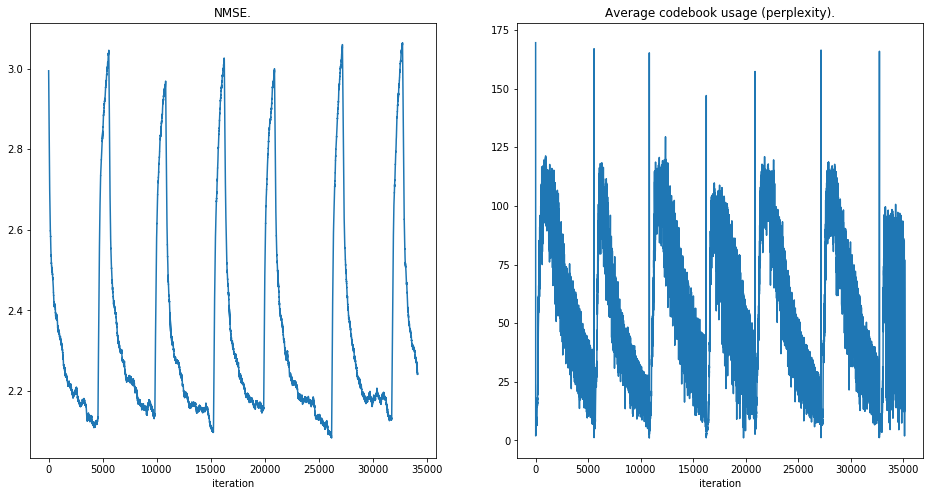

In [55]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(smooth_loss)
#ax.set_yscale('log')
ax.set_title('NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [ ]:
torch.save(model.state_dict(), "mymodel")
torch.save(optimizer.state_dict(), "myoptim")

In [ ]:
import pickle
with open("errors", "wb") as file:
    pickle.dump([train_res_recon_error, train_res_perplexity], file)

In [ ]:
#test encoding-decoding
# import librosa
# audio, sr = librosa.load("../VCTK/wav48/p225/p225_001.wav")
# normalized = librosa.util.normalize(audio) #divide max(abs(audio))
# mu_x = data.mu_law_encode(normalized, 256)
# bins = np.linspace(-1, 1, 256)
# quantized = np.digitize(mu_x, bins) - 1
# plt.plot(quantized[:100])
# plt.show()

# mu_rec = (quantized + 1) / 128 - 1
# plt.plot(mu_rec[:1000], color='red')
# plt.plot(mu_x[:1000], color='blue')
# plt.show()

# decoded = data.mu_law_decode(mu_rec, 256)
# plt.plot(normalized[:1000], color='blue')
# plt.plot(decoded[:1000], color='red')
# plt.show()

In [ ]:
model.eval()

data_train = data[train_indices[1]]
data_train = [data_train[0].to(device).unsqueeze(0), 
                  data_train[1].to(device).unsqueeze(0),
                  data_train[2].to(device).unsqueeze(0)]
valid_originals = data_train[0]
speaker_id = data_train[2]

with torch.no_grad():
    encoded = model._encoder(valid_originals)
    encoded -= model.mean
    encoded /= model.std
    _, valid_quantize, _ = model._vq_vae(encoded)
    #valid_reconstructions = model._decoder(valid_originals, valid_quantize, speaker_id) - this one works fine
    valid_reconstructions = model._decoder.incremental_forward(valid_originals[:,:,0:1], 
                                                               valid_quantize, 
                                                               speaker_id, 
                                                               T=16126)

In [ ]:
plt.plot(valid_quantize.detach().cpu().numpy().ravel())
plt.show()

In [ ]:
recon = valid_reconstructions.squeeze().argmax(dim=0).detach().cpu().numpy()
plt.plot(recon)
plt.show()

In [ ]:
orig = valid_originals.squeeze().argmax(dim=0).detach().cpu().numpy()
#plt.plot(valid_quantize.detach().numpy().ravel())
plt.plot(orig)
plt.show()

In [ ]:
recon = valid_reconstructions.squeeze().argmax(dim=0).detach().cpu().numpy()
mu_encoded = (recon + 1) / 128 - 1
mu_decoded = data.mu_law_decode(mu_encoded, mu=256)
plt.plot(mu_decoded)
plt.show()

In [ ]:
recon = valid_originals.squeeze().argmax(dim=0).detach().cpu().numpy()
mu_encoded_orig = (recon + 1) / 128 - 1
mu_decoded_orig = data.mu_law_decode(mu_encoded_orig, mu=256)
plt.plot(mu_decoded_orig)
plt.show()

In [ ]:
from IPython.display import Audio, display

In [ ]:
display(Audio(mu_decoded, rate=22050))

In [ ]:
display(Audio(mu_decoded_orig, rate=22050))

## View Embedding

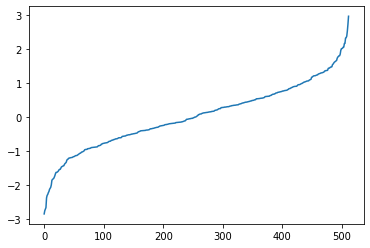

In [56]:
embeddings = model._vq_vae._embedding.weight.data.cpu()
plt.plot(sorted(embeddings))
plt.show()